In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)

iteration:,   0, ps_str, 1282.155082
iteration:,   1, ps_str, 13044.013784
iteration:,   2, ps_str, 148.081582
iteration:,   3, ps_str, 13043.368231
iteration:,   4, ps_str, 13044.061969
iteration:,   5, ps_str, 148.081582
iteration:,   6, ps_str, 13048.541853
iteration:,   7, ps_str, 13044.723159
iteration:,   8, ps_str, 148.081582
iteration:,   9, ps_str, 13045.974204
iteration:,  10, ps_str, 514.736161
iteration:,  11, ps_str, 148.081582
iteration:,  12, ps_str, 1282.131130
iteration:,  13, ps_str, 148.081582
iteration:,  14, ps_str, 148.081582
iteration:,  15, ps_str, 514.861576
iteration:,  16, ps_str, 13046.282617
iteration:,  17, ps_str, 13046.261367
iteration:,  18, ps_str, 148.081582
iteration:,  19, ps_str, 148.081582
iteration:,  20, ps_str, 13044.861964
iteration:,  21, ps_str, 13044.586281
iteration:,  22, ps_str, 514.474631
iteration:,  23, ps_str, 13042.154340
iteration:,  24, ps_str, 13044.659978
iteration:,  25, ps_str, 148.081582
iteration:,  26, ps_str, 148.081582
it

In [2]:
#Nanorod scattering spectrum
#Curvature Constant

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_spectrum_nanorod_cyl(length, wvl_min, wvl_max):

    r = 7.25E-3  # radius of cylinder
    l = length # length of cylinder
    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    frq_min = 1 / wvl_max
    frq_max = 1 / wvl_min
    frq_cen = 0.5 * (frq_min + frq_max)
    dfrq = frq_max - frq_min
    nfrq = 100
    
    resolution = 32/r
    
    dpml = 2*r
    pml_layers = [mp.PML(thickness=dpml)]
    
    #symmetries = [mp.Mirror(mp.Y)]
    
    s = 2*l + 2*dpml
    cell_size = mp.Vector3(s, s)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
        mp.Source(
            mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
            center=mp.Vector3(-0.5*s + dpml),
            size=mp.Vector3(0, s),
            component=mp.Hz,
        )
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        default_material = default_material,
        k_point=mp.Vector3()
    )
    
    
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= -0.5*l), size=mp.Vector3(l, 0)),
    )
    
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= 0.5*l), size=mp.Vector3(l, 0)),
    )
    
    sim.run(until_after_sources=10)
    
    freqs = mp.get_flux_freqs(box_x1)
    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    
    box_x1_flux0 = mp.get_fluxes(box_x1)
    
    sim.reset_meep()



    #axis says the orentation of the cylinder
    cylinder = mp.Cylinder(material=Au,
                           radius=r,
                           height=l,
                           center=mp.Vector3(),
                           axis=mp.Vector3(0, 1))
    
    geometry = [cylinder]
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        default_material = default_material,
        k_point=mp.Vector3(),
        geometry=geometry,
    )
    
    
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= -0.5*l), size=mp.Vector3(l, 0)),
    )
    
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= 0.5*l), size=mp.Vector3(l, 0)),
    )
    
    
    
    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    
    sim.run(until_after_sources=100)
    
    #flux power through each flux region.
    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)
    
    
    #Just want to plot the power of the scattered flux against wavelength
    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
    )

    return scatt_flux, freqs, l


In [3]:

wvl_min = 400E-3
wvl_max = 1000E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []
l_labels = []

l_min =10E-3
l_max =35E-3
lengths = np.linspace(l_max,l_min,20)

index = 1

for length in lengths:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs, length = get_spectrum_nanorod_cyl(length, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)
    freq_data.append(freqs)
    l_labels = np.append(l_labels, length)

    index+=1


##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000429153 s
Working in 2D dimensions.
Computational cell is 0.0990078 x 0.0990078 x 0 with resolution 4413.79
time for set_epsilon = 0.177582 s
-----------
Meep progress: 0.30653906250000007/16.666666507720947 = 1.8% done in 4.0s, 213.5s to go
on time step 2706 (time=0.306539), 0.00147827 s/step
Meep progress: 0.6143242187500001/16.666666507720947 = 3.7% done in 8.0s, 209.1s to go
on time step 5423 (time=0.614324), 0.00147227 s/step
Meep progress: 0.8733984375000001/16.666666507720947 = 5.2% done in 12.0s, 217.0s to go
on time step 7711 (time=0.873512), 0.0017489 s/step
Meep progress: 1.1218242187500003/16.666666507720947 = 6.7% done in 16.0s, 221.7s to go
on time step 9905 (time=1.12205), 0.00182412 s/step
Meep progress: 1.3407968750000003/16.666666507720947 = 8.0% done in 20.0s, 228.7s to go
on time step 11840 (time=1.34125), 0.0020683 s/step
Meep progr

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000501156 s
Working in 2D dimensions.
Computational cell is 0.0990078 x 0.0990078 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.035, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.26746 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.10682421875000002/106.66666650772095 = 0.1% done in 4.0s, 3990.3s to go
on time step 943 (time=0.106824), 0.00424242 s/step
Meep progress: 0.21568750000000003/106.66666650772095 = 0.2% done in 8.0s, 3950.3s to go
on time step 1904 (time=0.215688), 0.00416384 s/step
Meep progress: 0.33248046875000004/106.66666650772095 = 0.3% done in 12.0s, 3840.6s to go
on time step 2935 (time=0.33248), 0.00388367 s/step
Meep progress: 

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000565052 s
Working in 2D dimensions.
Computational cell is 0.0962891 x 0.0962891 x 0 with resolution 4413.79
time for set_epsilon = 0.396782 s
-----------
Meep progress: 0.21013671875000003/16.666666507720947 = 1.3% done in 4.0s, 313.4s to go
on time step 1855 (time=0.210137), 0.00215713 s/step
Meep progress: 0.4178945312500001/16.666666507720947 = 2.5% done in 8.0s, 311.2s to go
on time step 3689 (time=0.417895), 0.00218124 s/step
Meep progress: 0.6306367187500002/16.666666507720947 = 3.8% done in 12.0s, 305.2s to go
on time step 5568 (time=0.63075), 0.00213011 s/step
Meep progress: 0.8415664062500001/16.666666507720947 = 5.0% done in 16.0s, 301.0s to go
on time step 7430 (time=0.84168), 0.00214939 s/step
Meep progress: 1.0555546875000001/16.666666507720947 = 6.3% done in 20.0s, 295.9s to go
on

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000667095 s
Working in 2D dimensions.
Computational cell is 0.0962891 x 0.0962891 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0336842, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.387279 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.08779296875000002/106.66666650772095 = 0.1% done in 4.0s, 4858.6s to go
on time step 775 (time=0.087793), 0.00516447 s/step
Meep progress: 0.18430859375000003/106.66666650772095 = 0.2% done in 8.0s, 4628.2s to go
on time step 1627 (time=0.184309), 0.00470406 s/step
Meep progress: 0.26496484375000007/106.66666650772095 = 0.2% done in 12.0s, 4826.6s to go
on time step 2339 (time=0.264965), 0.00562839 s/step
Meep prog

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00154018 s
Working in 2D dimensions.
Computational cell is 0.0937969 x 0.0937969 x 0 with resolution 4413.79
time for set_epsilon = 0.421259 s
-----------
Meep progress: 0.19903515625000004/16.666666507720947 = 1.2% done in 4.0s, 331.1s to go
on time step 1757 (time=0.199035), 0.00227776 s/step
Meep progress: 0.41064453125000006/16.666666507720947 = 2.5% done in 8.0s, 316.8s to go
on time step 3625 (time=0.410645), 0.00214133 s/step
Meep progress: 0.6017500000000001/16.666666507720947 = 3.6% done in 12.0s, 320.5s to go
on time step 5312 (time=0.60175), 0.00237163 s/step
Meep progress: 0.7558125000000001/16.666666507720947 = 4.5% done in 16.0s, 336.9s to go
on time step 6673 (time=0.755926), 0.00294166 s/step
Meep progress: 0.8716992187500001/16.666666507720947 = 5.2% done in 20.0s, 362.5s to go
o

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000613928 s
Working in 2D dimensions.
Computational cell is 0.0937969 x 0.0937969 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0323684, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.381442 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.09492968750000001/106.66666650772095 = 0.1% done in 4.0s, 4492.2s to go
on time step 838 (time=0.0949297), 0.00477524 s/step
Meep progress: 0.19269140625000003/106.66666650772095 = 0.2% done in 8.0s, 4423.1s to go
on time step 1701 (time=0.192691), 0.00463725 s/step
Meep progress: 0.29022656250000006/106.66666650772095 = 0.3% done in 12.0s, 4400.4s to go
on time step 2562 (time=0.290227), 0.00464604 s/step
Meep pro

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000412941 s
Working in 2D dimensions.
Computational cell is 0.0910781 x 0.0910781 x 0 with resolution 4413.79
time for set_epsilon = 0.291891 s
-----------
Meep progress: 0.25805468750000005/16.666666507720947 = 1.5% done in 4.0s, 254.5s to go
on time step 2278 (time=0.258055), 0.00175677 s/step
Meep progress: 0.4920937500000001/16.666666507720947 = 3.0% done in 8.0s, 263.0s to go
on time step 4345 (time=0.492207), 0.00193578 s/step
Meep progress: 0.7483359375000002/16.666666507720947 = 4.5% done in 12.0s, 255.3s to go
on time step 6608 (time=0.748563), 0.00176827 s/step
Meep progress: 1.02961328125/16.666666507720947 = 6.2% done in 16.0s, 243.0s to go
on time step 9093 (time=1.03007), 0.00160972 s/step
Meep progress: 1.3166679687500003/16.666666507720947 = 7.9% done in 20.0s, 233.2s to go
on tim

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000473022 s
Working in 2D dimensions.
Computational cell is 0.0910781 x 0.0910781 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0310526, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.303518 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.10444531250000001/106.66666650772095 = 0.1% done in 4.0s, 4081.1s to go
on time step 922 (time=0.104445), 0.00433866 s/step
Meep progress: 0.21206250000000004/106.66666650772095 = 0.2% done in 8.0s, 4017.0s to go
on time step 1872 (time=0.212063), 0.00421105 s/step
Meep progress: 0.3197929687500001/106.66666650772095 = 0.3% done in 12.0s, 3992.4s to go
on time step 2823 (time=0.319793), 0.00420849 s/step
Meep progr

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000818968 s
Working in 2D dimensions.
Computational cell is 0.0885859 x 0.0885859 x 0 with resolution 4413.79
time for set_epsilon = 0.301018 s
-----------
Meep progress: 0.2555625/16.666666507720947 = 1.5% done in 4.0s, 256.9s to go
on time step 2256 (time=0.255563), 0.00177326 s/step
Meep progress: 0.5105585937500001/16.666666507720947 = 3.1% done in 8.0s, 253.2s to go
on time step 4507 (time=0.510559), 0.00177772 s/step
Meep progress: 0.7651015625000002/16.666666507720947 = 4.6% done in 12.0s, 249.5s to go
on time step 6756 (time=0.765328), 0.00177922 s/step
Meep progress: 1.0245156250000003/16.666666507720947 = 6.1% done in 16.0s, 244.4s to go
on time step 9046 (time=1.02474), 0.00174733 s/step
Meep progress: 1.2697695312500001/16.666666507720947 = 7.6% done in 20.0s, 242.6s to go
on time ste

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000535011 s
Working in 2D dimensions.
Computational cell is 0.0885859 x 0.0885859 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0297368, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.260759 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.11883203125000003/106.66666650772095 = 0.1% done in 4.0s, 3589.6s to go
on time step 1049 (time=0.118832), 0.00381666 s/step
Meep progress: 0.23607812500000003/106.66666650772095 = 0.2% done in 8.0s, 3608.7s to go
on time step 2084 (time=0.236078), 0.00386486 s/step
Meep progress: 0.35355078125000006/106.66666650772095 = 0.3% done in 12.0s, 3610.6s to go
on time step 3121 (time=0.353551), 0.00385897 s/step
Meep pro

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00040102 s
Working in 2D dimensions.
Computational cell is 0.0858672 x 0.0858672 x 0 with resolution 4413.79
time for set_epsilon = 0.270213 s
-----------
Meep progress: 0.30155468750000003/16.666666507720947 = 1.8% done in 4.0s, 217.1s to go
on time step 2662 (time=0.301555), 0.00150297 s/step
Meep progress: 0.5772812500000001/16.666666507720947 = 3.5% done in 8.0s, 223.0s to go
on time step 5096 (time=0.577281), 0.00164354 s/step
Meep progress: 0.8393007812500002/16.666666507720947 = 5.0% done in 12.0s, 226.4s to go
on time step 7409 (time=0.839301), 0.00172942 s/step
Meep progress: 1.0992812500000002/16.666666507720947 = 6.6% done in 16.0s, 226.6s to go
on time step 9705 (time=1.09939), 0.00174268 s/step
Meep progress: 1.3539375000000002/16.666666507720947 = 8.1% done in 20.0s, 226.2s to go
on

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000306129 s
Working in 2D dimensions.
Computational cell is 0.0858672 x 0.0858672 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0284211, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.176703 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.14669921875000003/106.66666650772095 = 0.1% done in 4.0s, 2907.0s to go
on time step 1295 (time=0.146699), 0.00309159 s/step
Meep progress: 0.27357421875000004/106.66666650772095 = 0.3% done in 8.0s, 3113.1s to go
on time step 2415 (time=0.273574), 0.00357214 s/step
Meep progress: 0.39285937500000007/106.66666650772095 = 0.4% done in 12.0s, 3248.2s to go
on time step 3468 (time=0.392859), 0.00380045 s/step
Meep pro

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000459909 s
Working in 2D dimensions.
Computational cell is 0.0831484 x 0.0831484 x 0 with resolution 4413.79
time for set_epsilon = 0.236401 s
-----------
Meep progress: 0.27787890625000006/16.666666507720947 = 1.7% done in 4.0s, 236.0s to go
on time step 2453 (time=0.277879), 0.00163104 s/step
Meep progress: 0.5497539062500001/16.666666507720947 = 3.3% done in 8.0s, 234.6s to go
on time step 4853 (time=0.549754), 0.00166673 s/step
Meep progress: 0.8477968750000001/16.666666507720947 = 5.1% done in 12.0s, 223.9s to go
on time step 7485 (time=0.84791), 0.00152008 s/step
Meep progress: 1.1379101562500002/16.666666507720947 = 6.8% done in 16.0s, 218.4s to go
on time step 10046 (time=1.13802), 0.00156197 s/step
Meep progress: 1.4777539062500002/16.666666507720947 = 8.9% done in 20.0s, 205.6s to go
o

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000422955 s
Working in 2D dimensions.
Computational cell is 0.0831484 x 0.0831484 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0271053, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.228997 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.14692578125000003/106.66666650772095 = 0.1% done in 4.0s, 2900.8s to go
on time step 1297 (time=0.146926), 0.00308506 s/step
Meep progress: 0.28456250000000005/106.66666650772095 = 0.3% done in 8.0s, 2991.5s to go
on time step 2512 (time=0.284563), 0.00329247 s/step
Meep progress: 0.42423828125000007/106.66666650772095 = 0.4% done in 12.0s, 3006.0s to go
on time step 3745 (time=0.424238), 0.00324449 s/step
Meep pro

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 2D dimensions.
Computational cell is 0.0806563 x 0.0806563 x 0 with resolution 4413.79
time for set_epsilon = 0.169154 s
-----------
Meep progress: 0.32568359375000006/16.666666507720947 = 2.0% done in 4.0s, 200.7s to go
on time step 2875 (time=0.325684), 0.00139144 s/step
Meep progress: 0.6194218750000001/16.666666507720947 = 3.7% done in 8.0s, 207.3s to go
on time step 5469 (time=0.619535), 0.00154238 s/step
Meep progress: 0.9011523437500002/16.666666507720947 = 5.4% done in 12.0s, 209.9s to go
on time step 7957 (time=0.901379), 0.00160803 s/step
Meep progress: 1.1923984375000003/16.666666507720947 = 7.2% done in 16.0s, 207.7s to go
on time step 10529 (time=1.19274), 0.0015553 s/step
Meep progress: 1.4816054687500002/16.666666507720947 = 8.9% done in 20.0s, 205.0s to go
o

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000358105 s
Working in 2D dimensions.
Computational cell is 0.0806563 x 0.0806563 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0257895, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.228272 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.14737890625000002/106.66666650772095 = 0.1% done in 4.0s, 2894.0s to go
on time step 1301 (time=0.147379), 0.00307794 s/step
Meep progress: 0.29396484375000004/106.66666650772095 = 0.3% done in 8.0s, 2897.4s to go
on time step 2595 (time=0.293965), 0.00309271 s/step
Meep progress: 0.4387382812500001/106.66666650772095 = 0.4% done in 12.0s, 2907.5s to go
on time step 3874 (time=0.438852), 0.00312987 s/step
Meep prog

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00048995 s
Working in 2D dimensions.
Computational cell is 0.0779375 x 0.0779375 x 0 with resolution 4413.79
time for set_epsilon = 0.185172 s
-----------
Meep progress: 0.4015820312500001/16.666666507720947 = 2.4% done in 4.0s, 162.0s to go
on time step 3545 (time=0.401582), 0.00112866 s/step
Meep progress: 0.8070156250000001/16.666666507720947 = 4.8% done in 8.0s, 157.2s to go
on time step 7125 (time=0.807129), 0.00111756 s/step
Meep progress: 1.1543359375000002/16.666666507720947 = 6.9% done in 12.0s, 161.3s to go
on time step 10191 (time=1.15445), 0.00130468 s/step
Meep progress: 1.4729960937500002/16.666666507720947 = 8.8% done in 16.0s, 165.1s to go
on time step 13003 (time=1.473), 0.00142292 s/step
Meep progress: 1.7858789062500002/16.666666507720947 = 10.7% done in 20.0s, 166.7s to go
on 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000435829 s
Working in 2D dimensions.
Computational cell is 0.0779375 x 0.0779375 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0244737, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.271989 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.15100390625000001/106.66666650772095 = 0.1% done in 4.0s, 2822.4s to go
on time step 1333 (time=0.151004), 0.00300177 s/step
Meep progress: 0.3056328125000001/106.66666650772095 = 0.3% done in 8.0s, 2785.4s to go
on time step 2698 (time=0.305633), 0.0029318 s/step
Meep progress: 0.46456640625000006/106.66666650772095 = 0.4% done in 12.0s, 2744.2s to go
on time step 4102 (time=0.46468), 0.00285002 s/step
Meep progre

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000416994 s
Working in 2D dimensions.
Computational cell is 0.0752188 x 0.0752188 x 0 with resolution 4413.79
time for set_epsilon = 0.107669 s
-----------
Meep progress: 0.5171289062500001/16.666666507720947 = 3.1% done in 4.0s, 124.9s to go
on time step 4565 (time=0.517129), 0.000876276 s/step
Meep progress: 1.0407148437500002/16.666666507720947 = 6.2% done in 8.0s, 120.1s to go
on time step 9188 (time=1.04083), 0.000865391 s/step
Meep progress: 1.5464023437500003/16.666666507720947 = 9.3% done in 12.0s, 117.3s to go
on time step 13654 (time=1.54674), 0.000895792 s/step
Meep progress: 2.0400820312500003/16.666666507720947 = 12.2% done in 16.0s, 114.7s to go
on time step 18015 (time=2.04076), 0.000917383 s/step
Meep progress: 2.5593632812500005/16.666666507720947 = 15.4% done in 20.0s, 110.3s t

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000316143 s
Working in 2D dimensions.
Computational cell is 0.0752188 x 0.0752188 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0231579, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.134842 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.19427734375000003/106.66666650772095 = 0.2% done in 4.0s, 2192.9s to go
on time step 1715 (time=0.194277), 0.00233327 s/step
Meep progress: 0.40124218750000007/106.66666650772095 = 0.4% done in 8.0s, 2119.3s to go
on time step 3543 (time=0.401355), 0.00218896 s/step
Meep progress: 0.5827187500000001/106.66666650772095 = 0.5% done in 12.0s, 2185.3s to go
on time step 5145 (time=0.582832), 0.00249852 s/step
Meep prog

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000684977 s
Working in 2D dimensions.
Computational cell is 0.0727266 x 0.0727266 x 0 with resolution 4413.79
time for set_epsilon = 0.139859 s
-----------
Meep progress: 0.4201601562500001/16.666666507720947 = 2.5% done in 4.0s, 154.7s to go
on time step 3709 (time=0.42016), 0.00107866 s/step
Meep progress: 0.7622695312500001/16.666666507720947 = 4.6% done in 8.0s, 166.9s to go
on time step 6730 (time=0.762383), 0.00132431 s/step
Meep progress: 1.1081171875000002/16.666666507720947 = 6.6% done in 12.0s, 168.5s to go
on time step 9784 (time=1.10834), 0.00130976 s/step
Meep progress: 1.5367734375000002/16.666666507720947 = 9.2% done in 16.0s, 157.5s to go
on time step 13570 (time=1.53723), 0.00105661 s/step
Meep progress: 1.9128671875000003/16.666666507720947 = 11.5% done in 20.0s, 154.3s to go
o

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000411034 s
Working in 2D dimensions.
Computational cell is 0.0727266 x 0.0727266 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0218421, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.118554 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.20934375000000002/106.66666650772095 = 0.2% done in 4.0s, 2034.7s to go
on time step 1848 (time=0.209344), 0.00216521 s/step
Meep progress: 0.40577343750000006/106.66666650772095 = 0.4% done in 8.0s, 2095.7s to go
on time step 3582 (time=0.405773), 0.00230708 s/step
Meep progress: 0.5815859375000001/106.66666650772095 = 0.5% done in 12.0s, 2189.6s to go
on time step 5134 (time=0.581586), 0.00257789 s/step
Meep prog

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000406981 s
Working in 2D dimensions.
Computational cell is 0.0700078 x 0.0700078 x 0 with resolution 4413.79
time for set_epsilon = 0.207229 s
-----------
Meep progress: 0.39025390625000006/16.666666507720947 = 2.3% done in 4.0s, 166.9s to go
on time step 3445 (time=0.390254), 0.00116138 s/step
Meep progress: 0.8766835937500002/16.666666507720947 = 5.3% done in 8.0s, 144.1s to go
on time step 7740 (time=0.876797), 0.000931385 s/step
Meep progress: 1.3585820312500003/16.666666507720947 = 8.2% done in 12.0s, 135.2s to go
on time step 11994 (time=1.3587), 0.000940539 s/step
Meep progress: 1.7750039062500003/16.666666507720947 = 10.7% done in 16.0s, 134.3s to go
on time step 15671 (time=1.77523), 0.00108791 s/step
Meep progress: 2.1740937500000004/16.666666507720947 = 13.0% done in 20.0s, 133.3s to

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000342131 s
Working in 2D dimensions.
Computational cell is 0.0700078 x 0.0700078 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0205263, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.190209 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.17264062500000002/106.66666650772095 = 0.2% done in 4.0s, 2468.3s to go
on time step 1524 (time=0.172641), 0.00262571 s/step
Meep progress: 0.34947265625000007/106.66666650772095 = 0.3% done in 8.0s, 2434.7s to go
on time step 3085 (time=0.349473), 0.00256314 s/step
Meep progress: 0.5241523437500001/106.66666650772095 = 0.5% done in 12.0s, 2430.7s to go
on time step 4628 (time=0.524266), 0.00259345 s/step
Meep prog

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000316143 s
Working in 2D dimensions.
Computational cell is 0.0675156 x 0.0675156 x 0 with resolution 4413.79
time for set_epsilon = 0.13745 s
-----------
Meep progress: 0.5555312500000001/16.666666507720947 = 3.3% done in 4.0s, 116.0s to go
on time step 4904 (time=0.555531), 0.000815827 s/step
Meep progress: 1.0504570312500001/16.666666507720947 = 6.3% done in 8.0s, 118.9s to go
on time step 9274 (time=1.05057), 0.000915498 s/step
Meep progress: 1.5902421875000003/16.666666507720947 = 9.5% done in 12.0s, 113.8s to go
on time step 14040 (time=1.59047), 0.000839428 s/step
Meep progress: 2.1338789062500005/16.666666507720947 = 12.8% done in 16.0s, 109.0s to go
on time step 18842 (time=2.13445), 0.000833113 s/step
Meep progress: 2.6180429687500006/16.666666507720947 = 15.7% done in 20.0s, 107.3s to

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000324965 s
Working in 2D dimensions.
Computational cell is 0.0675156 x 0.0675156 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0192105, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.129367 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.23358593750000003/106.66666650772095 = 0.2% done in 4.0s, 1823.3s to go
on time step 2062 (time=0.233586), 0.00194072 s/step
Meep progress: 0.4338671875000001/106.66666650772095 = 0.4% done in 8.0s, 1959.2s to go
on time step 3831 (time=0.43398), 0.00226202 s/step
Meep progress: 0.6322226562500001/106.66666650772095 = 0.6% done in 12.0s, 2013.0s to go
on time step 5583 (time=0.632449), 0.00228386 s/step
Meep progre

Meep progress: 106.65599609375002/106.66666650772095 = 100.0% done in 1960.6s, 0.2s to go
run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000357151 s
Working in 2D dimensions.
Computational cell is 0.0647969 x 0.0647969 x 0 with resolution 4413.79
time for set_epsilon = 0.1281 s
-----------
Meep progress: 0.4754414062500001/16.666666507720947 = 2.9% done in 4.0s, 136.2s to go
on time step 4197 (time=0.475441), 0.000953295 s/step
Meep progress: 0.9227890625000001/16.666666507720947 = 5.5% done in 8.0s, 136.5s to go
on time step 8147 (time=0.922902), 0.00101288 s/step
Meep progress: 1.4038945312500002/16.666666507720947 = 8.4% done in 12.0s, 130.5s to go
on time step 12397 (time=1.40435), 0.000941198 s/step
Meep progress: 1.9782304687500003/16.666666507720947 = 11.9% done in 16.0s, 118.8s to go
on time step 17469 (time=1.97891), 0.000788745 s/s

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286818 s
Working in 2D dimensions.
Computational cell is 0.0647969 x 0.0647969 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0178947, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.114848 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.22531640625000005/106.66666650772095 = 0.2% done in 4.0s, 1890.3s to go
on time step 1989 (time=0.225316), 0.00201185 s/step
Meep progress: 0.4440625000000001/106.66666650772095 = 0.4% done in 8.0s, 1914.4s to go
on time step 3920 (time=0.444063), 0.00207189 s/step
Meep progress: 0.6527265625000002/106.66666650772095 = 0.6% done in 12.0s, 1949.6s to go
on time step 5763 (time=0.65284), 0.00217117 s/step
Meep progre

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000644207 s
Working in 2D dimensions.
Computational cell is 0.0620781 x 0.0620781 x 0 with resolution 4413.79
time for set_epsilon = 0.144451 s
-----------
Meep progress: 0.42344531250000006/16.666666507720947 = 2.5% done in 4.0s, 153.5s to go
on time step 3738 (time=0.423445), 0.00107036 s/step
Meep progress: 0.8417929687500001/16.666666507720947 = 5.1% done in 8.0s, 150.4s to go
on time step 7432 (time=0.841906), 0.00108306 s/step
Meep progress: 1.2673906250000002/16.666666507720947 = 7.6% done in 12.0s, 145.8s to go
on time step 11190 (time=1.26762), 0.00106456 s/step
Meep progress: 1.7000117187500003/16.666666507720947 = 10.2% done in 16.0s, 140.9s to go
on time step 15010 (time=1.70035), 0.00104728 s/step
Meep progress: 2.1287812500000003/16.666666507720947 = 12.8% done in 20.0s, 136.6s to 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000495911 s
Working in 2D dimensions.
Computational cell is 0.0620781 x 0.0620781 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0165789, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.164643 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.24672656250000005/106.66666650772095 = 0.2% done in 4.0s, 1725.9s to go
on time step 2178 (time=0.246727), 0.00183726 s/step
Meep progress: 0.4971914062500001/106.66666650772095 = 0.5% done in 8.0s, 1708.7s to go
on time step 4390 (time=0.497305), 0.00180902 s/step
Meep progress: 0.7411992187500002/106.66666650772095 = 0.7% done in 12.0s, 1715.2s to go
on time step 6545 (time=0.741426), 0.00185685 s/step
Meep progr

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000400066 s
Working in 2D dimensions.
Computational cell is 0.0595859 x 0.0595859 x 0 with resolution 4413.79
time for set_epsilon = 0.114658 s
-----------
Meep progress: 0.5017226562500001/16.666666507720947 = 3.0% done in 4.0s, 128.9s to go
on time step 4429 (time=0.501723), 0.000903266 s/step
Meep progress: 1.0903320312500002/16.666666507720947 = 6.5% done in 8.0s, 114.3s to go
on time step 9626 (time=1.09045), 0.000769701 s/step
Meep progress: 1.7960742187500003/16.666666507720947 = 10.8% done in 12.0s, 99.4s to go
on time step 15858 (time=1.79641), 0.000641948 s/step
Meep progress: 2.3441289062500004/16.666666507720947 = 14.1% done in 16.0s, 97.8s to go
on time step 20696 (time=2.34447), 0.000826813 s/step
Meep progress: 2.8657890625000007/16.666666507720947 = 17.2% done in 20.0s, 96.3s to 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000240088 s
Working in 2D dimensions.
Computational cell is 0.0595859 x 0.0595859 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0152632, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.0872171 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.3126562500000001/106.66666650772095 = 0.3% done in 4.0s, 1360.9s to go
on time step 2760 (time=0.312656), 0.00144961 s/step
Meep progress: 0.5816992187500001/106.66666650772095 = 0.5% done in 8.0s, 1459.3s to go
on time step 5135 (time=0.581699), 0.00168437 s/step
Meep progress: 0.8576523437500001/106.66666650772095 = 0.8% done in 12.0s, 1480.8s to go
on time step 7572 (time=0.857766), 0.00164192 s/step
Meep progr

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000324965 s
Working in 2D dimensions.
Computational cell is 0.0568672 x 0.0568672 x 0 with resolution 4413.79
time for set_epsilon = 0.106892 s
-----------
Meep progress: 0.6940742187500001/16.666666507720947 = 4.2% done in 4.0s, 92.1s to go
on time step 6127 (time=0.694074), 0.000652901 s/step
Meep progress: 1.4847773437500003/16.666666507720947 = 8.9% done in 8.0s, 81.8s to go
on time step 13109 (time=1.485), 0.000572926 s/step
Meep progress: 2.3188671875000004/16.666666507720947 = 13.9% done in 12.0s, 74.3s to go
on time step 20472 (time=2.31909), 0.000543276 s/step
Meep progress: 3.1440078125000004/16.666666507720947 = 18.9% done in 16.0s, 68.8s to go
on time step 27758 (time=3.14446), 0.000549002 s/step
Meep progress: 3.950683593750001/16.666666507720947 = 23.7% done in 20.0s, 64.4s to go
o

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 2D dimensions.
Computational cell is 0.0568672 x 0.0568672 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0139474, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.091542 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.3281757812500001/106.66666650772095 = 0.3% done in 4.0s, 1296.2s to go
on time step 2897 (time=0.328176), 0.00138091 s/step
Meep progress: 0.6654140625000001/106.66666650772095 = 0.6% done in 8.0s, 1274.6s to go
on time step 5874 (time=0.665414), 0.00134365 s/step
Meep progress: 1.0416210937500001/106.66666650772095 = 1.0% done in 12.0s, 1217.0s to go
on time step 9195 (time=1.04162), 0.00120447 s/step
Meep progres

Meep progress: 106.65327734375002/106.66666650772095 = 100.0% done in 1324.3s, 0.2s to go
run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000905991 s
Working in 2D dimensions.
Computational cell is 0.054375 x 0.054375 x 0 with resolution 4413.79
time for set_epsilon = 0.113494 s
-----------
Meep progress: 0.5769414062500001/16.666666507720947 = 3.5% done in 4.0s, 111.6s to go
on time step 5093 (time=0.576941), 0.000785437 s/step
Meep progress: 1.1672500000000001/16.666666507720947 = 7.0% done in 8.0s, 106.2s to go
on time step 10306 (time=1.16748), 0.000767411 s/step
Meep progress: 1.8742382812500002/16.666666507720947 = 11.2% done in 12.0s, 94.7s to go
on time step 16549 (time=1.87469), 0.00064077 s/step
Meep progress: 2.6881640625000003/16.666666507720947 = 16.1% done in 16.0s, 83.2s to go
on time step 23733 (time=2.6885), 0.000556871 s/ste

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231981 s
Working in 2D dimensions.
Computational cell is 0.054375 x 0.054375 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0126316, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.0686331 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.41766796875000006/106.66666650772095 = 0.4% done in 4.0s, 1018.0s to go
on time step 3687 (time=0.417668), 0.00108545 s/step
Meep progress: 0.8579921875000002/106.66666650772095 = 0.8% done in 8.0s, 986.8s to go
on time step 7575 (time=0.858105), 0.00102887 s/step
Meep progress: 1.2566289062500002/106.66666650772095 = 1.2% done in 12.0s, 1006.8s to go
on time step 11095 (time=1.25686), 0.00113653 s/step
Meep progres

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279188 s
Working in 2D dimensions.
Computational cell is 0.0516563 x 0.0516563 x 0 with resolution 4413.79
time for set_epsilon = 0.064214 s
-----------
Meep progress: 0.8544804687500002/16.666666507720947 = 5.1% done in 4.0s, 74.0s to go
on time step 7543 (time=0.85448), 0.000530326 s/step
Meep progress: 1.8286992187500004/16.666666507720947 = 11.0% done in 8.0s, 64.9s to go
on time step 16144 (time=1.82881), 0.000465074 s/step
Meep progress: 2.6112460937500006/16.666666507720947 = 15.7% done in 12.0s, 64.6s to go
on time step 23053 (time=2.61147), 0.000578969 s/step
Meep progress: 3.4497539062500007/16.666666507720947 = 20.7% done in 16.0s, 61.3s to go
on time step 30458 (time=3.45032), 0.000540233 s/step
Meep progress: 4.327910156250001/16.666666507720947 = 26.0% done in 20.0s, 57.0s to go

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281811 s
Working in 2D dimensions.
Computational cell is 0.0516563 x 0.0516563 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0113158, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.077677 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.4502929687500001/106.66666650772095 = 0.4% done in 4.0s, 943.5s to go
on time step 3975 (time=0.450293), 0.00100635 s/step
Meep progress: 0.8545937500000002/106.66666650772095 = 0.8% done in 8.0s, 990.6s to go
on time step 7545 (time=0.854707), 0.00112077 s/step
Meep progress: 1.2931054687500003/106.66666650772095 = 1.2% done in 12.0s, 978.0s to go
on time step 11418 (time=1.29345), 0.00103297 s/step
Meep progress:

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000225067 s
Working in 2D dimensions.
Computational cell is 0.0489375 x 0.0489375 x 0 with resolution 4413.79
time for set_epsilon = 0.0496399 s
-----------
Meep progress: 0.9606250000000002/16.666666507720947 = 5.8% done in 4.0s, 65.4s to go
on time step 8480 (time=0.960625), 0.000471733 s/step
Meep progress: 1.6970664062500003/16.666666507720947 = 10.2% done in 8.0s, 70.6s to go
on time step 14982 (time=1.69718), 0.000615212 s/step
Meep progress: 2.4404179687500003/16.666666507720947 = 14.6% done in 12.0s, 70.0s to go
on time step 21546 (time=2.44076), 0.000609434 s/step
Meep progress: 3.3797460937500006/16.666666507720947 = 20.3% done in 16.0s, 62.9s to go
on time step 29840 (time=3.38031), 0.000482301 s/step
Meep progress: 4.400296875/16.666666507720947 = 26.4% done in 20.0s, 55.8s to go
on 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00039506 s
Working in 2D dimensions.
Computational cell is 0.0489375 x 0.0489375 x 0 with resolution 4413.79
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.01, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.108865 s
lorentzian susceptibility: frequency=0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.40135546875000006/106.66666650772095 = 0.4% done in 4.0s, 1059.3s to go
on time step 3543 (time=0.401355), 0.0011293 s/step
Meep progress: 0.8203828125000001/106.66666650772095 = 0.8% done in 8.0s, 1032.3s to go
on time step 7243 (time=0.820496), 0.00108118 s/step
Meep progress: 1.2387304687500003/106.66666650772095 = 1.2% done in 12.0s, 1021.5s to go
on time step 10937 (time=1.23896), 0.001083 s/step
Meep progress: 1.71

[3.50000000e-02 5.59322034e+02]
[3.36842105e-02 5.59322034e+02]
[3.23684211e-02 5.54621849e+02]
[3.10526316e-02 5.54621849e+02]
[2.97368421e-02 5.54621849e+02]
[2.84210526e-02 5.54621849e+02]
[2.71052632e-02 5.50000000e+02]
[2.57894737e-02 5.50000000e+02]
[2.44736842e-02 5.50000000e+02]
[2.31578947e-02 5.45454545e+02]
[2.18421053e-02 5.45454545e+02]
[2.05263158e-02 5.45454545e+02]
[1.92105263e-02 5.45454545e+02]
[1.78947368e-02 5.45454545e+02]
[1.65789474e-02 5.45454545e+02]
[1.52631579e-02 5.45454545e+02]
[1.39473684e-02 5.45454545e+02]
[1.26315789e-02 5.45454545e+02]
[1.13157895e-02 5.40983607e+02]
[1.00000000e-02 5.36585366e+02]
[3.5e-02 1.0e+03]
[3.36842105e-02 1.00000000e+03]
[3.23684211e-02 1.00000000e+03]
[3.10526316e-02 1.00000000e+03]
[2.97368421e-02 1.00000000e+03]
[2.84210526e-02 1.00000000e+03]
[2.71052632e-02 1.00000000e+03]
[2.57894737e-02 1.00000000e+03]
[2.44736842e-02 1.00000000e+03]
[2.31578947e-02 1.00000000e+03]
[2.18421053e-02 1.00000000e+03]
[2.05263158e-02 1.0000

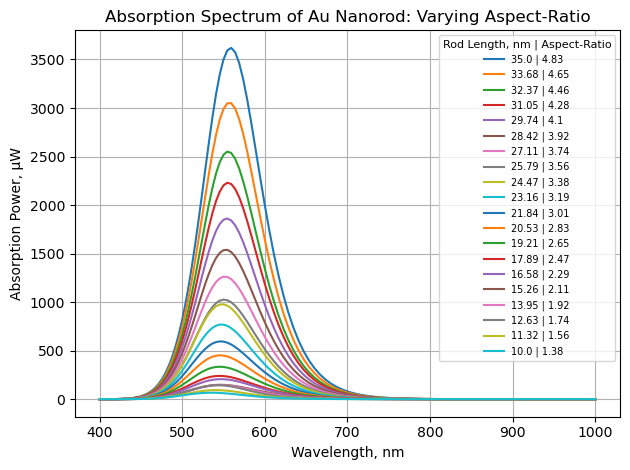

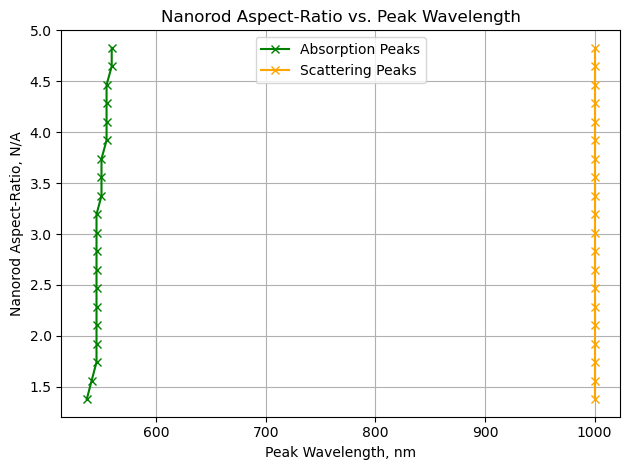

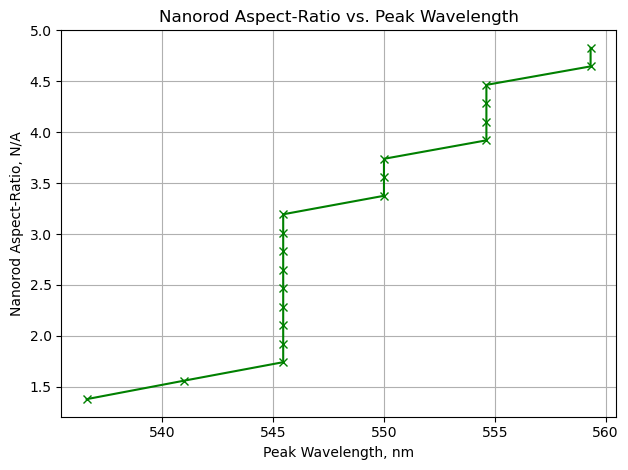

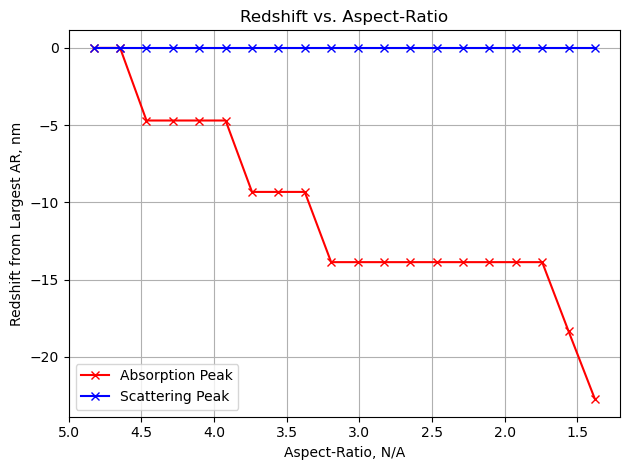

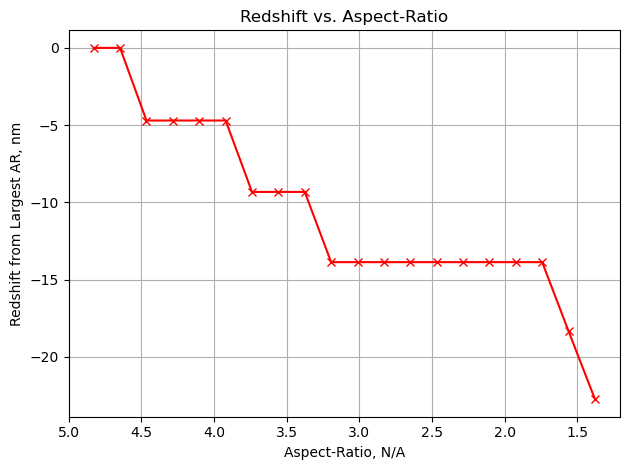

In [4]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.
#

plt.figure()
for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    length = lengths[index]
    AR = float(length)/(7.25E-3)
    
    plt.plot(1E3/freqs, -1*scatt_flux*10E6, "-", label=f"{str(1E3*round(float(length),5))[:5]} | {round(AR,2)}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, μW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Rod Length, nm | Aspect-Ratio", fontsize = 7, title_fontsize= 8)
    plt.title("Absorption Spectrum of Au Nanorod: Varying Aspect-Ratio")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append([length, max_wvl_ab])
    max_wvls_sc.append([length, max_wvl_sc])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Spectrum of Au Nanorod: Varying Aspect-Ratio",
            dpi=150, 
            bbox_inches="tight")

max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)

for row in max_wvls_ab:
    print(row)

for row in max_wvls_sc:
    print(row)

#plot curvature vs. peak position

plt.figure()
plt.plot(max_wvls_ab[:,1], max_wvls_ab[:,0]/(7.25E-3), "gx-", label="Absorption Peaks")
plt.plot(max_wvls_sc[:,1], max_wvls_sc[:,0]/(7.25E-3), "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanorod Aspect-Ratio, N/A")
plt.title("Nanorod Aspect-Ratio vs. Peak Wavelength")
plt.tight_layout()
plt.legend(loc="upper center")
plt.savefig(fname="Nanorod Aspecect-Ratio vs Peak Wavelength, both peaks",
            dpi=150, 
            bbox_inches="tight")

plt.figure()
plt.plot(max_wvls_ab[:,1], max_wvls_ab[:,0]/(7.25E-3), "gx-", label="Absorption Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanorod Aspect-Ratio, N/A")
plt.title("Nanorod Aspect-Ratio vs. Peak Wavelength")
plt.tight_layout()
plt.savefig(fname="Nanorod AR vs Peak Wavelength, one peaks",
            dpi=150, 
            bbox_inches="tight")



#Plot of redshift vs. AR

AR = lengths/(7.25E-3) #AR=length/width
redshift_ab = max_wvls_ab[:,1]-max_wvls_ab[0,1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:,1]-max_wvls_sc[0,1]

plt.figure()
plt.plot(AR, redshift_ab, "rx-", label="Absorption Peak")
plt.plot(AR, redshift_sc, "bx-", label="Scattering Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Aspect-Ratio, N/A")
plt.ylabel("Redshift from Largest AR, nm")
plt.title("Redshift vs. Aspect-Ratio")
plt.tight_layout()
plt.legend(loc="lower left")
plt.savefig(fname="Redshift vs Aspect-Ratio, both peaks",
            dpi=150, 
            bbox_inches="tight")


plt.figure()
plt.plot(AR, redshift_ab, "rx-", label="Absorption Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Aspect-Ratio, N/A")
plt.ylabel("Redshift from Largest AR, nm")
plt.title("Redshift vs. Aspect-Ratio")
plt.tight_layout()
plt.savefig(fname="Redshift vs Aspect-Ratio, one peaks",
            dpi=150, 
            bbox_inches="tight")


